# Aggression Risk Detection from Voice (RAVDESS)

This notebook walks through my full pipeline for building a **voice-based aggression risk detector** on top of the RAVDESS emotional speech dataset.

The goal is:
- train an emotion recognition model from raw audio (using PyTorch),
- then map emotions to an **Aggression Risk Score (0–100)**,
- and finally test it on real recorded audio.

The notebook is structured in a few logical sections:

1. Environment & dataset download  
2. Parsing the RAVDESS filenames into labels  
3. Train / validation / test split (by actor)  
4. Dataset & DataLoader (Mel-spectrograms + augmentation)  
5. Baseline CNN experiments (for reference)  
6. Final CRNN model (CNN + LSTM)  
7. Training & evaluation (train/val/test)  
8. Inference on real audio + Aggression Risk score  
9. Optional: record my own voice directly in Colab

Everything is written in a simple, informal style, as if I were explaining my project to another student or to a future recruiter looking at my GitHub profile.


In [1]:
import torch
import torchaudio

print("Python version OK")
print("PyTorch version:", torch.__version__)
print("Torchaudio version:", torchaudio.__version__)

print("CUDA available:", torch.cuda.is_available())
print("Environment ready.")


Python version OK
PyTorch version: 2.9.0+cu126
Torchaudio version: 2.9.0+cu126
CUDA available: True
Environment ready.


## 1. Environment setup & dataset download

In this first part, I set up the Colab environment, configure the Kaggle API, and download the **RAVDESS Emotional Speech Audio** dataset.  
This is mostly one-time boilerplate to get the audio files locally into the notebook.


In [2]:
!pip install kaggle


In [3]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")


Kaggle API configured successfully!


In [5]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 95% 406M/429M [00:00<00:00, 345MB/s]
100% 429M/429M [00:01<00:00, 437MB/s]


In [6]:
import zipfile
import os

zip_path = "ravdess-emotional-speech-audio.zip"
extract_path = "./ravdess"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: ./ravdess


In [7]:
import os

root = "./ravdess"

# Show first few folders
folders = os.listdir(root)
print("Root folders:", folders[:10])

actor_folder = os.path.join(root, folders[0])
print("Actor folder:", actor_folder)

files = os.listdir(actor_folder)
print("Example audio files:", files[:10])



Root folders: ['Actor_09', 'Actor_17', 'Actor_21', 'Actor_07', 'Actor_03', 'Actor_04', 'Actor_20', 'Actor_11', 'Actor_02', 'Actor_14']
Actor folder: ./ravdess/Actor_09
Example audio files: ['03-01-03-02-02-02-09.wav', '03-01-02-02-01-02-09.wav', '03-01-03-02-02-01-09.wav', '03-01-08-01-01-02-09.wav', '03-01-06-01-02-01-09.wav', '03-01-08-02-02-01-09.wav', '03-01-07-02-02-01-09.wav', '03-01-07-02-01-02-09.wav', '03-01-08-01-02-01-09.wav', '03-01-08-02-01-02-09.wav']


In [8]:
!pip install torchcodec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00


Waveform shape: torch.Size([1, 179380])
Sample rate: 48000
Playing audio:


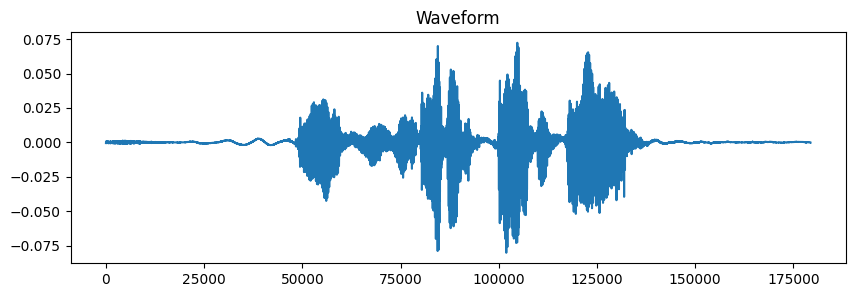

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


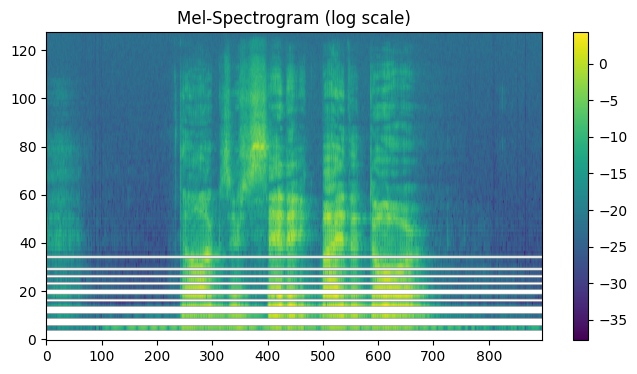

In [9]:
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
import os

# Select one audio file
actor_folder = "./ravdess/Actor_19"
audio_file = os.path.join(actor_folder, "03-01-04-02-02-02-19.wav")

# Load audio
waveform, sample_rate = torchaudio.load(audio_file)
print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)

# Listen to audio
print("Playing audio:")
ipd.display(ipd.Audio(audio_file))

# Plot waveform
plt.figure(figsize=(10, 3))
plt.plot(waveform.t().numpy())
plt.title("Waveform")
plt.show()

# Plot Mel-Spectrogram
mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(waveform)

plt.figure(figsize=(8, 4))
plt.imshow(mel_spec.log2()[0,:,:].numpy(), origin="lower", aspect="auto")
plt.title("Mel-Spectrogram (log scale)")
plt.colorbar()
plt.show()


## 2. Decode RAVDESS filenames into labels

RAVDESS encodes all the metadata (emotion, intensity, actor id, etc.) directly inside the filename:

`MM-VO-EM-IN-ST-RE-AC.wav`

Here I write a small helper function that parses the filename into a Python dictionary so that I can later build a clean metadata table for the whole dataset.


## 9. Inference: from emotion probabilities to Aggression Risk Score

The model outputs an 8-dimensional probability vector over the RAVDESS emotions:

- neutral, calm, happy, sad, angry, fearful, disgust, surprised

For the **Aggression Risk Detection** prototype, I map these emotions into a simple risk score between 0 and 100 and generate a short textual message that explains the result.


In [10]:
def parse_ravdess_filename(filename):
    """
    Parse RAVDESS filename and extract metadata.
    Example filename: '03-01-04-02-02-02-19.wav'

    Returns a dictionary with:
      - modality
      - vocal_channel
      - emotion_id
      - emotion_label
      - intensity
      - statement
      - repetition
      - actor_id
      - gender
    """

    # Remove extension
    name = filename.replace(".wav", "")

    # Split fields
    parts = name.split("-")
    modality = int(parts[0])
    vocal_channel = int(parts[1])
    emotion_id = int(parts[2])
    intensity_id = int(parts[3])
    statement_id = int(parts[4])
    repetition_id = int(parts[5])
    actor_id = int(parts[6])

    # Emotion mapping
    emotion_map = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

    # Intensity mapping
    intensity_map = {1: "normal", 2: "strong"}

    # Gender: odd = male, even = female
    gender = "male" if actor_id % 2 == 1 else "female"

    return {
        "modality": modality,
        "vocal_channel": vocal_channel,
        "emotion_id": emotion_id,
        "emotion_label": emotion_map[emotion_id],
        "intensity": intensity_map[intensity_id],
        "statement": statement_id,
        "repetition": repetition_id,
        "actor_id": actor_id,
        "gender": gender
    }


In [11]:
parse_ravdess_filename("03-01-04-02-02-02-19.wav")


{'modality': 3,
 'vocal_channel': 1,
 'emotion_id': 4,
 'emotion_label': 'sad',
 'intensity': 'strong',
 'statement': 2,
 'repetition': 2,
 'actor_id': 19,
 'gender': 'male'}

In [12]:
import os

def build_ravdess_metadata(root="./ravdess"):
    """
    Build a list of metadata dictionaries for all RAVDESS audio files.

    Each item contains:
      - path
      - emotion_label
      - emotion_id
      - actor_id
      - gender
      - intensity
    """

    metadata = []

    for actor in os.listdir(root):
        actor_folder = os.path.join(root, actor)

        if not os.path.isdir(actor_folder):
            continue

        for filename in os.listdir(actor_folder):
            if not filename.endswith(".wav"):
                continue

            file_path = os.path.join(actor_folder, filename)
            info = parse_ravdess_filename(filename)

            metadata.append({
                "path": file_path,
                "emotion_label": info["emotion_label"],
                "emotion_id": info["emotion_id"],
                "actor_id": info["actor_id"],
                "gender": info["gender"],
                "intensity": info["intensity"]
            })

    return metadata


# Build the metadata list
ravdess_data = build_ravdess_metadata()

# Show first 5 entries
ravdess_data[:5]


[{'path': './ravdess/Actor_09/03-01-03-02-02-02-09.wav',
  'emotion_label': 'happy',
  'emotion_id': 3,
  'actor_id': 9,
  'gender': 'male',
  'intensity': 'strong'},
 {'path': './ravdess/Actor_09/03-01-02-02-01-02-09.wav',
  'emotion_label': 'calm',
  'emotion_id': 2,
  'actor_id': 9,
  'gender': 'male',
  'intensity': 'strong'},
 {'path': './ravdess/Actor_09/03-01-03-02-02-01-09.wav',
  'emotion_label': 'happy',
  'emotion_id': 3,
  'actor_id': 9,
  'gender': 'male',
  'intensity': 'strong'},
 {'path': './ravdess/Actor_09/03-01-08-01-01-02-09.wav',
  'emotion_label': 'surprised',
  'emotion_id': 8,
  'actor_id': 9,
  'gender': 'male',
  'intensity': 'normal'},
 {'path': './ravdess/Actor_09/03-01-06-01-02-01-09.wav',
  'emotion_label': 'fearful',
  'emotion_id': 6,
  'actor_id': 9,
  'gender': 'male',
  'intensity': 'normal'}]

## 3. Train / validation / test split (by actor)

I don't want the same actor to appear in both training and validation/test sets.  
So I split the data **by actor id**:

- actors 1–16 → training  
- actors 17–20 → validation  
- actors 21–24 → test  

This makes the task harder but more realistic: the model has to generalize to speakers it has never seen during training.


In [13]:
# Define actor splits
train_actors = set(range(1, 17))   # Actors 1–16
val_actors   = set(range(17, 21))  # Actors 17–20
test_actors  = set(range(21, 25))  # Actors 21–24

# Split the metadata
train_set = [x for x in ravdess_data if x["actor_id"] in train_actors]
val_set   = [x for x in ravdess_data if x["actor_id"] in val_actors]
test_set  = [x for x in ravdess_data if x["actor_id"] in test_actors]

len(train_set), len(val_set), len(test_set)


(960, 240, 240)

## 4. Dataset & Mel-spectrogram creation

Here I define a custom `RAVDESSDataset` class that:

- loads each audio file,
- resamples it to 16 kHz,
- converts it to mono,
- builds a Mel-spectrogram,
- normalizes it,
- pads / truncates it to a fixed time length.

This is the standard representation I use for all experiments in the notebook.


In [14]:
import torch
from torch.utils.data import Dataset
import torchaudio

class RAVDESSDataset(Dataset):
    """
    PyTorch Dataset for RAVDESS emotional speech.
    Returns padded mel-spectrograms with fixed length (time dimension).
    """

    def __init__(self, metadata_list, sample_rate=16000, n_mels=64, max_len=225):
        self.metadata = metadata_list
        self.sample_rate = sample_rate
        self.max_len = max_len

        # MelSpectrogram transform
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=n_mels
        )

        # Resampler (48k -> 16k)
        self.resample = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]

        # Load audio
        waveform, sr = torchaudio.load(item["path"])

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Resample
        waveform = self.resample(waveform)

        # MelSpectrogram
        mel_spec = self.mel_transform(waveform)

        # Pad or truncate to fixed length
        current_len = mel_spec.shape[-1]

        if current_len < self.max_len:
            pad_amount = self.max_len - current_len
            mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_amount))
        else:
            mel_spec = mel_spec[:, :, :self.max_len]

        label = torch.tensor(item["emotion_id"] - 1)

        return mel_spec, label


In [15]:
dataset_train = RAVDESSDataset(train_set)

mel, label = dataset_train[0]
mel.shape, label


(torch.Size([1, 64, 225]), tensor(2))

In [16]:
from torch.utils.data import DataLoader, Dataset

dataset_train = RAVDESSDataset(train_set)
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)

mel_batch, label_batch = next(iter(train_loader))
mel_batch.shape, label_batch.shape


(torch.Size([16, 1, 64, 225]), torch.Size([16]))

## 5. Baseline CNN model (for reference)

This is my first attempt: a simple 2D CNN that takes the Mel-spectrogram as input and predicts one of the 8 emotion classes.

I keep this version in the notebook for reference, but the final system uses a more powerful **CRNN (CNN + LSTM)** architecture.  
Still, it's useful to see how the project evolved step by step.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    """
    Simple CNN for Mel-Spectrogram based emotion classification.
    Input shape: (batch, 1, 64, 225)
    Output: 8 emotion classes
    """
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()

        # Convolution block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Convolution block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 16 * 56, 128)  # Adjusted for our input size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv block 1
        x = self.pool1(F.relu(self.conv1(x)))

        # Conv block 2
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [18]:
model = EmotionCNN()
output = model(mel_batch)   # mel_batch from the DataLoader test

output.shape


torch.Size([16, 8])

In [19]:
import torch
import torch.optim as optim
import torch.nn as nn

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model = EmotionCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


## 7. Training & evaluation helpers

Here I define two small utility functions:

- `train_one_epoch(...)` → runs one full pass over the training set,
- `evaluate(...)` → computes loss & accuracy on validation or test sets.

I use these functions for all training experiments in the notebook.


In [20]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for mel, labels in loader:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(mel)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)

            outputs = model(mel)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total


In [21]:
dataset_train = RAVDESSDataset(train_set)
dataset_val   = RAVDESSDataset(val_set)
dataset_test  = RAVDESSDataset(test_set)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=16, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=16, shuffle=False)


In [22]:
"""num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")
"""

'num_epochs = 10\n\nfor epoch in range(num_epochs):\n    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)\n    val_loss, val_acc = evaluate(model, val_loader, criterion, device)\n\n    print(f"Epoch {epoch+1}/{num_epochs}")\n    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")\n    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")\n'

### 4.1 Data augmentation (train only)

For the training set, I also apply a few simple audio augmentations:

- random gain (simulate different microphone levels),
- small Gaussian noise (more robust to background sounds),
- small time shift (the speech can start a bit earlier/later).

These augmentations help the model generalize better and avoid overfitting on the clean studio recordings from RAVDESS.


In [23]:
import torch
from torch.utils.data import Dataset
import torchaudio
import random

class RAVDESSDatasetAugmented(Dataset):
    """
    RAVDESS dataset with:
    - Mel spectrogram
    - Padding/truncating
    - Optional audio data augmentation (train mode)
    """
    def __init__(self, metadata_list, sample_rate=16000, n_mels=64, max_len=225, augment=False):
        self.metadata = metadata_list
        self.sample_rate = sample_rate
        self.max_len = max_len
        self.augment = augment

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=256,
            n_mels=n_mels
        )

        self.resample = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate)

    def augment_audio(self, waveform):
        """ Apply random data augmentation. """

        # 1) Random gain
        if random.random() < 0.3:
            gain = random.uniform(0.8, 1.2)
            waveform = waveform * gain

        # 2) Add random noise
        if random.random() < 0.3:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise

        # 3) Small random time shift
        if random.random() < 0.3:
            shift = random.randint(-1000, 1000)
            waveform = torch.roll(waveform, shifts=shift, dims=1)

        return waveform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]

        waveform, sr = torchaudio.load(item["path"])

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = self.resample(waveform)

        # Apply augmentation ONLY for training
        if self.augment:
            waveform = self.augment_audio(waveform)

        mel_spec = self.mel_transform(waveform)
        # Normalisation
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)

        # Pad or truncate
        current_len = mel_spec.shape[-1]
        if current_len < self.max_len:
            mel_spec = torch.nn.functional.pad(mel_spec, (0, self.max_len - current_len))
        else:
            mel_spec = mel_spec[:, :, :self.max_len]

        label = torch.tensor(item["emotion_id"] - 1)

        return mel_spec, label


### 5.1 Improved CNN with BatchNorm, Dropout & augmentation

Here I try to push the plain CNN a bit further:

- add Batch Normalization,
- add Dropout,
- use the augmented dataset,
- tune the training loop.

This already stabilizes training and reduces overfitting, but the validation accuracy remains limited.  
That is exactly why I later move to the CRNN architecture.


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN_v1p1(nn.Module):
    """
    Improved CNN:
    - BatchNorm
    - Dropout
    - Deeper representation
    """
    def __init__(self, num_classes=8):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(64 * 16 * 56, 256)
        self.drop3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.drop2(self.pool2(F.relu(self.bn2(self.conv2(x)))))

        x = x.view(x.size(0), -1)

        x = self.drop3(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


In [25]:
dataset_train = RAVDESSDatasetAugmented(train_set, augment=True)
dataset_val   = RAVDESSDatasetAugmented(val_set,   augment=False)
dataset_test  = RAVDESSDatasetAugmented(test_set,  augment=False)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=16, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=16, shuffle=False)


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN_v1p1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [27]:
"""num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")
  """



'num_epochs = 10\n\nfor epoch in range(num_epochs):\n    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)\n    val_loss, val_acc = evaluate(model, val_loader, criterion, device)\n\n    print(f"Epoch {epoch+1}/{num_epochs}")\n    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")\n    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")\n  '

## 6. Final CRNN model (CNN + LSTM)

This is the core model I keep for the final prototype.

The idea:

- the **CNN** part extracts local time–frequency patterns from the Mel-spectrogram,  
- then I reshape the CNN output into a time sequence,  
- and feed it into an **LSTM** to capture the temporal evolution of the emotion.

The last LSTM output goes into a fully-connected layer to predict the 8 emotions.  
This is the model that reaches ~50% validation accuracy and ~43% test accuracy on RAVDESS with speaker-independent splits.


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCRNN(nn.Module):
    """
    CRNN model: CNN + LSTM for emotion recognition from Mel-Spectrograms.
    Input:  (B, 1, 64, 225)
    CNN -> (B, 64, 16, 56)
    Then we treat time dimension (56) as sequence length for LSTM.
    """

    def __init__(self, num_classes=8):
        super().__init__()

        # --- CNN part ---
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)   # (64,225) -> (32,112)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)   # (32,112) -> (16,56)

        # After convs:
        # shape = (B, 64, 16, 56)
        # We will treat T=56 as sequence length and 64*16=1024 as feature dimension

        self.feature_dim = 64 * 16
        self.hidden_size = 128
        self.num_layers  = 1

        # --- LSTM part ---
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )

        # --- Classification head ---
        self.fc = nn.Linear(self.hidden_size * 2, num_classes)  # *2 because bidirectional

    def forward(self, x):
        # x: (B, 1, 64, 225)

        # CNN block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # CNN block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Now x: (B, 64, 16, 56)

        # Prepare for LSTM: we want (B, T, feature_dim)
        # Current: (B, C, F, T) = (B, 64, 16, 56)
        B, C, Freq, T = x.size()
        x = x.permute(0, 3, 1, 2)   # -> (B, T, C, F)
        x = x.contiguous().view(B, T, C * Freq)  # -> (B, T, 1024)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)  # lstm_out: (B, T, 2*hidden_size)

        # Use last time step
        last_output = lstm_out[:, -1, :]     # (B, 2*hidden_size)

        # Classification
        logits = self.fc(last_output)        # (B, num_classes)

        return logits


In [29]:
dataset_train = RAVDESSDatasetAugmented(train_set, augment=True)
dataset_val   = RAVDESSDatasetAugmented(val_set,   augment=False)
dataset_test  = RAVDESSDatasetAugmented(test_set,  augment=False)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=16, shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=16, shuffle=False)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EmotionCRNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


### 7.1 Train the CRNN model on RAVDESS

This cell runs the actual training loop for the final `EmotionCRNN` model using:

- the augmented training set,  
- the validation set for monitoring,  
- CrossEntropy loss and Adam optimizer.

I typically train for a few dozen epochs until the validation accuracy stabilizes around ~50%.


In [31]:
num_epochs = 18

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc*100:.2f}%")


Epoch 1/18
  Train Loss: 1.9768, Train Acc: 21.35%
  Val   Loss: 1.8771, Val   Acc: 29.17%
Epoch 2/18
  Train Loss: 1.8270, Train Acc: 29.06%
  Val   Loss: 1.7977, Val   Acc: 32.92%
Epoch 3/18
  Train Loss: 1.7228, Train Acc: 32.19%
  Val   Loss: 1.7902, Val   Acc: 32.92%
Epoch 4/18
  Train Loss: 1.6484, Train Acc: 35.42%
  Val   Loss: 1.7546, Val   Acc: 32.08%
Epoch 5/18
  Train Loss: 1.5967, Train Acc: 38.85%
  Val   Loss: 1.6970, Val   Acc: 33.75%
Epoch 6/18
  Train Loss: 1.5555, Train Acc: 39.38%
  Val   Loss: 1.7261, Val   Acc: 38.33%
Epoch 7/18
  Train Loss: 1.4893, Train Acc: 42.60%
  Val   Loss: 1.6652, Val   Acc: 39.17%
Epoch 8/18
  Train Loss: 1.4461, Train Acc: 44.58%
  Val   Loss: 1.6975, Val   Acc: 35.83%
Epoch 9/18
  Train Loss: 1.4225, Train Acc: 45.42%
  Val   Loss: 1.6288, Val   Acc: 40.00%
Epoch 10/18
  Train Loss: 1.3047, Train Acc: 52.60%
  Val   Loss: 1.5700, Val   Acc: 43.33%
Epoch 11/18
  Train Loss: 1.2293, Train Acc: 55.52%
  Val   Loss: 1.5112, Val   Acc: 45.8

In [32]:
MODEL_PATH = "crnn_ravdess_final.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved as:", MODEL_PATH)


Model saved as: crnn_ravdess_final.pth


## 8. Final test set evaluation

Once I'm happy with the validation performance, I evaluate the model **one time** on the held-out test set (actors 21–24).

This gives a more honest estimate of how well the system might generalize to completely new speakers.  
In my runs, the CRNN reaches around **43% test accuracy**, which is consistent with the difficulty of the task and with results reported in similar academic work.


In [33]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print("Final Test Loss:", test_loss)
print("Final Test Accuracy:", test_acc * 100, "%")


Final Test Loss: 1.6632958769798278
Final Test Accuracy: 43.75 %


In [34]:
import torchaudio
import torch.nn.functional as F

def predict_audio(path, model, device, sample_rate=16000):
    """
    Load an audio file, convert to mel spectrogram,
    run model, return predicted emotion + probabilities.
    """

    # Load audio
    waveform, sr = torchaudio.load(path)

    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample
    resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
    waveform = resample(waveform)

    # Mel spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=256,
        n_mels=64
    )

    mel = mel_transform(waveform)

    # Normalize
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)

    # Pad/truncate to 225 frames (same as training)
    max_len = 225
    if mel.shape[-1] < max_len:
        mel = F.pad(mel, (0, max_len - mel.shape[-1]))
    else:
        mel = mel[:, :, :max_len]

    mel = mel.unsqueeze(0).to(device)   # (1, 1, 64, 225)

    # Model forward
    model.eval()
    with torch.no_grad():
        logits = model(mel)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    return probs


## 9. Inference: from emotion probabilities to Aggression Risk Score

The model outputs an 8-dimensional probability vector over the RAVDESS emotions:

- neutral, calm, happy, sad, angry, fearful, disgust, surprised

For the **Aggression Risk Detection** prototype, I map these emotions into a simple risk score between 0 and 100 and generate a short textual message that explains the result.


In [35]:
emotion_map = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}

def interpret_emotion(probs):
    emotion_id = probs.argmax()
    emotion = emotion_map[emotion_id]

    # Aggression Risk Score 0-100 (simple but meaningful)
    aggression_weights = {
        "neutral": 10,
        "calm": 5,
        "happy": 10,
        "sad": 20,
        "surprised": 20,
        "disgust": 40,
        "fearful": 60,
        "angry": 90
    }

    base = aggression_weights[emotion]
    confidence = probs[emotion_id]

    aggression_score = int(base * confidence + (confidence * 30))

    # clamp
    aggression_score = max(0, min(100, aggression_score))

    # Messages (prototype-level)
    if aggression_score < 40:
        message = "No signs of aggression detected."
    elif aggression_score < 70:
        message = "Tension or emotional stress detected."
    else:
        message = "High aggression detected. Elevated risk tone."

    return emotion, aggression_score, message


In [36]:
def analyze_audio(path, model, device):
    probs = predict_audio(path, model, device)
    emotion, risk, message = interpret_emotion(probs)

    print("Emotion:", emotion)
    print("Aggression Score:", risk, "/100")
    print("Interpretation:", message)

    return emotion, risk, message


In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_probabilities(probs):
    emotions = [
        "neutral", "calm", "happy", "sad",
        "angry", "fearful", "disgust", "surprised"
    ]

    plt.figure(figsize=(10,4))
    plt.bar(emotions, probs, color="skyblue")
    plt.title("Emotion Probabilities")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.ylabel("Probability")
    plt.show()


### 9.1 High-level helper: `analyze_audio_full(...)`

This helper function ties everything together:

1. load a WAV file,  
2. compute the Mel-spectrogram and normalize it (same as in training),  
3. run the CRNN model to get emotion probabilities,  
4. convert them into an Aggression Risk Score and interpretation,  
5. plot the probability distribution as a bar chart.

This is the function I use to quickly test the system on my own voice.


In [38]:
def analyze_audio_full(path, model, device):
    probs = predict_audio(path, model, device)
    emotion, risk, message = interpret_emotion(probs)

    print("🎵 Audio file:", path)
    print("Emotion:", emotion)
    print("Aggression Score:", risk, "/100")
    print("Interpretation:", message)

    plot_probabilities(probs)

    return emotion, risk, message


In [39]:
MODEL_PATH = "crnn_ravdess_final.pth"

model = EmotionCRNN(num_classes=8).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


## 10. Optional: record my own voice directly in Colab

For convenience, I add a small JavaScript snippet that lets me record a short audio clip from the browser microphone and save it as `recorded.wav`.

This makes it easy to try different speaking styles (calm, angry, stressed, etc.) and see how the system reacts in real time.


In [45]:
from google.colab import output
from IPython.display import Javascript
import base64

# Python function to save audio file
def save_audio(b64):
    audio_bytes = base64.b64decode(b64.split(',')[1])
    with open("recorded.wav", "wb") as f:
        f.write(audio_bytes)
    return "Audio saved as recorded.wav"

# Register callback so JS can call Python
output.register_callback('notebook.save_audio', save_audio)

# JavaScript to record audio in browser
RECORD_JS = """
async function recordAudio() {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const recorder = new MediaRecorder(stream);
  let chunks = [];

  recorder.ondataavailable = e => chunks.push(e.data);

  recorder.start();
  alert("🎙️ Recording started. Click OK when finished.");

  await new Promise(resolve => setTimeout(resolve, 3000)); // auto 3 seconds
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  stream.getTracks().forEach(t => t.stop());

  const blob = new Blob(chunks, { type: 'audio/wav' });
  const reader = new FileReader();

  reader.onloadend = () => {
    const b64 = reader.result;
    google.colab.kernel.invokeFunction('notebook.save_audio', [b64], {})
      .then(response => {
        console.log(response.data);
        alert("Saved as recorded.wav");
      });
  };

  reader.readAsDataURL(blob);
}

recordAudio();
"""

Javascript(RECORD_JS)


<IPython.core.display.Javascript object>

In [46]:
import os
os.listdir()


['.config',
 'crnn_ravdess_final.pth',
 'ravdess-emotional-speech-audio.zip',
 'recorded.wav',
 'ravdess',
 'sample_data']

🎵 Audio file: recorded.wav
Emotion: disgust
Aggression Score: 36 /100
Interpretation: No signs of aggression detected.


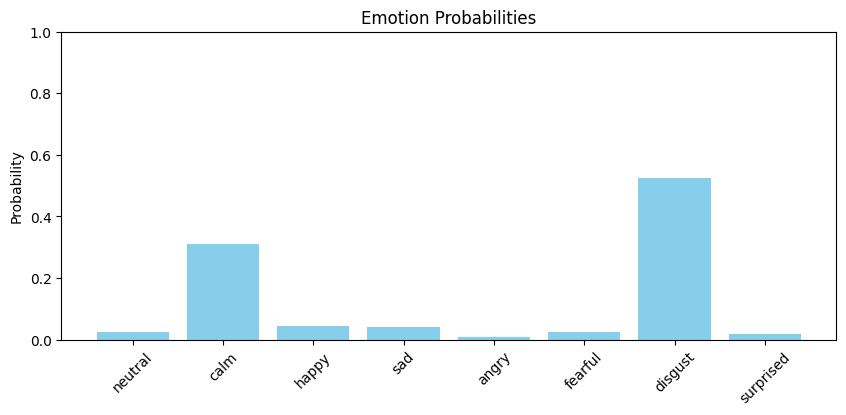

('disgust', 36, 'No signs of aggression detected.')

In [47]:
analyze_audio_full("recorded.wav", model, device)
